# Question 4: Optimising pre-processing and feature extraction (50 marks)

**Note:** it is advisable to implement question 4 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

This Question is about improving the model’s performance through multiple optimization techniques. I experimented with different preprocessing steps like lemmatization and stopword removal, expand features with bigrams, and adjust hyperparameters such as the SVM regularization value (C).
I also introduce TF-IDF weighting and add stylistic and lexicon based features to see how much each step improves the classifier’s accuracy and F1 score

# NOTE: After doing all the experimentation needed, i formulated this notebook in a sequence, from importing all the required libraries upfront, to developing base line model to optimization processes.

# Importing all the required libraries needed for the model

In [1]:
# Core Python utilities
import csv
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLTK librearies
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import SklearnClassifier

# Machine Learning (scikit-learn)
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

# External data fetching (for lexicons)
import requests

# Display utilities
from IPython.display import display, HTML

# Sseeds for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


# STEP 1: BASELINE MODEL SETUP AND EVALUATION FROM Q1 -Q3, CONNECTING Q4

In [2]:
# Loading and Preprocessing Data
raw_data, train_data, test_data = [], [], []
global_feature_dict = {}


def parse_data_line(data_line):
    return (data_line[1], data_line[2])

def pre_process(text):
    return text.split()  

def to_feature_vector(tokens):
    feature_vector = {}
    for token in tokens:
        token = token.lower()
        feature_vector[token] = feature_vector.get(token, 0) + 1
        global_feature_dict[token] = global_feature_dict.get(token, 0) + 1
    return feature_vector

def load_data(path):
    with open(path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))


def split_and_preprocess_data(percentage):
    num_samples = len(raw_data)
    num_training_samples = int(percentage * num_samples)
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)), label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)), label))

# Setting up Classifier
def train_classifier(data):
    print("Training baseline classifier...")
    pipeline = Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

def predict_labels(samples, classifier):
    return classifier.classify_many(samples)

# Laoding the dataset
data_file_path = "sentiment-dataset.tsv"  
load_data(data_file_path)
raw_data = shuffle(raw_data, random_state=42)
split_and_preprocess_data(0.8)


# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])


({'#independent': 1, 'ludacris': 1, 'wraps': 1, 'up': 1, 'his': 1, '10th': 1, 'anniversary': 1, 'of': 1, 'ludaday': 1, 'weekend:': 1, 'step': 1, 'aside': 1, 'labor': 1, 'day,': 1, 'the...': 1, 'http://t.co/hr9yqjwvmi': 1, '#news': 1, '#world': 1}, 'positive')
Training baseline classifier...
Done training!
Precision: 0.838273
Recall: 0.840042
F Score:0.838353


# Step 2: Improved Preprocessing (Tokenization, Stopwords, Lemmatization)

In [3]:
# Downloading the required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
print("NLTK resources downloaded successfully!")

def pre_process(text):
    """
    Improved preprocessing:
    - Lowercasing
    - Tokenization
    - Stopword removal
    - Punctuation removal
    - Lemmatization
    """
    tokens = nltk.word_tokenize(text.lower())

    # Removing punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    # Lemmatizing to normalize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens


NLTK resources downloaded successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\udayk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\udayk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\udayk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\udayk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Evaluating model after improved preprocessing.
raw_data, train_data, test_data = [], [], []
load_data(data_file_path)
split_and_preprocess_data(0.8)

print("Training model with improved preprocessing...")
classifier = train_classifier(train_data)

test_true = [t[1] for t in test_data]
test_pred = predict_labels([x[0] for x in test_data], classifier)

final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted', zero_division=0)

print("\n Model with Improved Preprocessing")
print(f"Precision: {final_scores[0]:.3f}")
print(f"Recall:    {final_scores[1]:.3f}")
print(f"F1 Score:  {final_scores[2]:.3f}")


Training model with improved preprocessing...
Training baseline classifier...

 Model with Improved Preprocessing
Precision: 0.841
Recall:    0.843
F1 Score:  0.842


# Step3: Feature Updation with Bigrams

In [5]:
# Updating the model fearture extraction with Unigrams & Bigrams.
def to_feature_vector(tokens):
   
    feature_vector = {}

    # Unigram features
    for token in tokens:
        feature_vector[token] = feature_vector.get(token, 0) + 1

    # Bigram features
    for bigram in ngrams(tokens, 2):
        feature = "_".join(bigram)  # Join pair with underscore
        feature_vector[feature] = feature_vector.get(feature, 0) + 1

    return feature_vector




In [6]:
# Initializing datasets to ensure updated preprocessing and feature extraction are applied
raw_data, train_data, test_data = [], [], []

# Loading and preprocessing the dataset
load_data(data_file_path)
split_and_preprocess_data(0.8)

functions_complete = True

if functions_complete:
    print("Training model with unigrams + bigrams...")
    classifier = train_classifier(train_data)

    # Evaluating the classifier on the test data
    test_true = [t[1] for t in test_data]
    test_pred = predict_labels([x[0] for x in test_data], classifier)

    from sklearn.metrics import precision_recall_fscore_support
    final_scores = precision_recall_fscore_support(
        test_true, test_pred, average='weighted', zero_division=0
    )

    print("\n=== Model with Unigrams + Bigrams ===")
    print(f"Precision: {final_scores[0]:.3f}")
    print(f"Recall:    {final_scores[1]:.3f}")
    print(f"F1 Score:  {final_scores[2]:.3f}")


Training model with unigrams + bigrams...
Training baseline classifier...

=== Model with Unigrams + Bigrams ===
Precision: 0.855
Recall:    0.857
F1 Score:  0.855


Observed a rise in the score from initial model after feature extraction using BiGrams.

# Step 4: Hyperparameter Optimization (C-Tuning)

In [7]:
# Hyperparameter Tuning:

# Defining a range of C values to explore (controls margin softness)
C_values = [0.1, 0.5, 1, 2, 3, 5, 10]
best_f1 = 0
best_c = None
results = []

# Training and evaluating the model for each C value
for c in C_values:
    print(f"\nTraining SVM with C={c}...")
    pipeline = Pipeline([('svc', LinearSVC(C=c, max_iter=5000))])
    classifier = SklearnClassifier(pipeline).train(train_data)

    # Evaluating performance
    test_true = [t[1] for t in test_data]
    test_pred = classifier.classify_many([x[0] for x in test_data])

    precision, recall, f1, _ = precision_recall_fscore_support(
        test_true, test_pred, average='weighted', zero_division=0
    )
    results.append((c, precision, recall, f1))

    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # Keeping track of best C
    if f1 > best_f1:
        best_f1 = f1
        best_c = c

# Printing summary of results
print("\n=== Summary of C Tuning ===")
for c, p, r, f in results:
    print(f"C={c:>4} | Precision={p:.3f} | Recall={r:.3f} | F1={f:.3f}")

print(f"\n Best C value: {best_c} with F1={best_f1:.3f}")



Training SVM with C=0.1...
Precision: 0.857, Recall: 0.859, F1: 0.857

Training SVM with C=0.5...
Precision: 0.855, Recall: 0.856, F1: 0.854

Training SVM with C=1...
Precision: 0.855, Recall: 0.857, F1: 0.855

Training SVM with C=2...
Precision: 0.854, Recall: 0.856, F1: 0.854

Training SVM with C=3...
Precision: 0.854, Recall: 0.856, F1: 0.853

Training SVM with C=5...
Precision: 0.854, Recall: 0.855, F1: 0.853

Training SVM with C=10...
Precision: 0.854, Recall: 0.856, F1: 0.853

=== Summary of C Tuning ===
C= 0.1 | Precision=0.857 | Recall=0.859 | F1=0.857
C= 0.5 | Precision=0.855 | Recall=0.856 | F1=0.854
C=   1 | Precision=0.855 | Recall=0.857 | F1=0.855
C=   2 | Precision=0.854 | Recall=0.856 | F1=0.854
C=   3 | Precision=0.854 | Recall=0.856 | F1=0.853
C=   5 | Precision=0.854 | Recall=0.855 | F1=0.853
C=  10 | Precision=0.854 | Recall=0.856 | F1=0.853

 Best C value: 0.1 with F1=0.857


Observed almost similar with a very minimal rise in the F1 score

# Step5: TF-IDF Feature Extraction

IMPLEMENTING TF-IDF INSTEAD OF BAG-OF-WORDS TO IMPROVE MODEL PERFORMANCE

In [8]:
# Reloading raw text data to use directly with TfidfVectorizer
raw_data, train_data, test_data = [], [], []
load_data(data_file_path)
split_and_preprocess_data(0.8)

# Extractning raw text and labels for TF–IDF training
split_point = int(0.8 * len(raw_data))
train_texts = [text for text, _ in raw_data[:split_point]]
train_labels = [label for _, label in raw_data[:split_point]]
test_texts = [text for text, _ in raw_data[split_point:]]
test_labels = [label for _, label in raw_data[split_point:]]

print("Training TF–IDF model...")

# Defining TF-IDF + SVM pipeline
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),   # unigrams + bigrams
        max_df=0.95,          # ignoring overly frequent words
        min_df=2              # ignoring extremely rare words
    )),
    ('svc', LinearSVC(C=0.1, max_iter=5000))
])

# Trainign and evaluating the model
tfidf_pipeline.fit(train_texts, train_labels)
test_pred = tfidf_pipeline.predict(test_texts)

precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_pred, average='weighted', zero_division=0
)

print("\n=== TF–IDF + SVM Results ===")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")


Training TF–IDF model...

=== TF–IDF + SVM Results ===
Precision: 0.857
Recall:    0.856
F1 Score:  0.851


Observed a slight drop in the F1 score compared with bag of words approach with optimized preprocessing.

# Step 6: Playing with Hyperparameter Tuning and different levels of N Grams

# Playing with the Hyperparameter Tuning, i.e. from 0.1, 0.5, 1, 1.5 ..... 10 etc and different N Grams till 5 Grams to check for better model accuracy.

In [9]:
# Reloading and splitting the data fresh for this experiment
raw_data, train_data, test_data = [], [], []
load_data(data_file_path)
split_point = int(0.8 * len(raw_data))

raw_data = shuffle(raw_data, random_state=42)


train_texts = [text for text, _ in raw_data[:split_point]]
train_labels = [label for _, label in raw_data[:split_point]]
test_texts  = [text for text, _ in raw_data[split_point:]]
test_labels = [label for _, label in raw_data[split_point:]]

# Defining parameter ranges
ngram_ranges = [(1, n) for n in range(1, 6)]   # unigrams to 5-grams
C_values = [0.1, 0.5, 1, 3, 5, 10]
results = []

print("Running full grid search (n-grams × C)...\n")

# Training and evaluating all combinations
for ngram_range in ngram_ranges:
    for C in C_values:
        print(f"Training TF–IDF + SVM with ngram_range={ngram_range} and C={C}...")
        model = Pipeline([
            ('tfidf', TfidfVectorizer(
                lowercase=True,
                stop_words='english',
                ngram_range=ngram_range,
                max_df=0.95,
                min_df=1
            )),
            ('svc', LinearSVC(C=C, max_iter=5000))
        ])

        model.fit(train_texts, train_labels)
        preds = model.predict(test_texts)

        precision, recall, f1, _ = precision_recall_fscore_support(
            test_labels, preds, average='weighted', zero_division=0
        )

        results.append((ngram_range, C, precision, recall, f1))
        print(f"F1 = {f1:.3f}\n")

# Summarizing results
print("\n=== Summary of All Experiments ===")
for ngram, C, p, r, f1 in results:
    print(f"n-grams={ngram}, C={C:>4} | Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")

# Identifying best configuration
best = max(results, key=lambda x: x[4])
print(f"\n Best Model → n-grams={best[0]}, C={best[1]}, F1={best[4]:.3f}")


Running full grid search (n-grams × C)...

Training TF–IDF + SVM with ngram_range=(1, 1) and C=0.1...
F1 = 0.851

Training TF–IDF + SVM with ngram_range=(1, 1) and C=0.5...
F1 = 0.862

Training TF–IDF + SVM with ngram_range=(1, 1) and C=1...
F1 = 0.858

Training TF–IDF + SVM with ngram_range=(1, 1) and C=3...
F1 = 0.849

Training TF–IDF + SVM with ngram_range=(1, 1) and C=5...
F1 = 0.841

Training TF–IDF + SVM with ngram_range=(1, 1) and C=10...
F1 = 0.832

Training TF–IDF + SVM with ngram_range=(1, 2) and C=0.1...
F1 = 0.832

Training TF–IDF + SVM with ngram_range=(1, 2) and C=0.5...
F1 = 0.858

Training TF–IDF + SVM with ngram_range=(1, 2) and C=1...
F1 = 0.862

Training TF–IDF + SVM with ngram_range=(1, 2) and C=3...
F1 = 0.862

Training TF–IDF + SVM with ngram_range=(1, 2) and C=5...
F1 = 0.862

Training TF–IDF + SVM with ngram_range=(1, 2) and C=10...
F1 = 0.862

Training TF–IDF + SVM with ngram_range=(1, 3) and C=0.1...
F1 = 0.824

Training TF–IDF + SVM with ngram_range=(1, 3) an

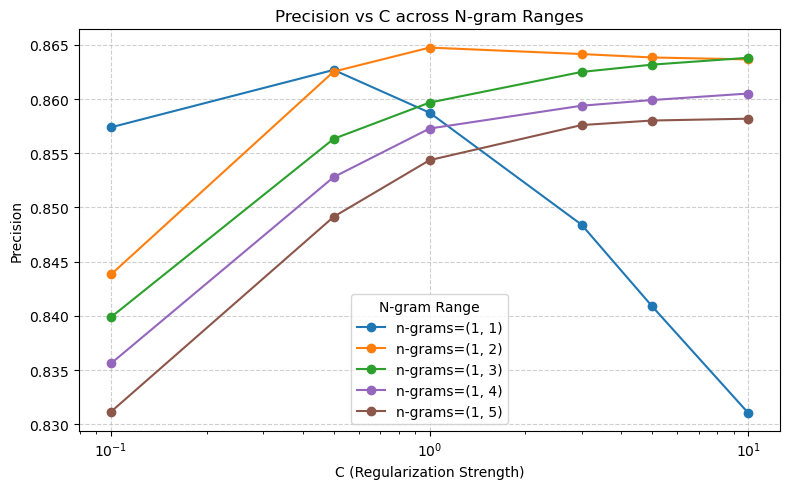

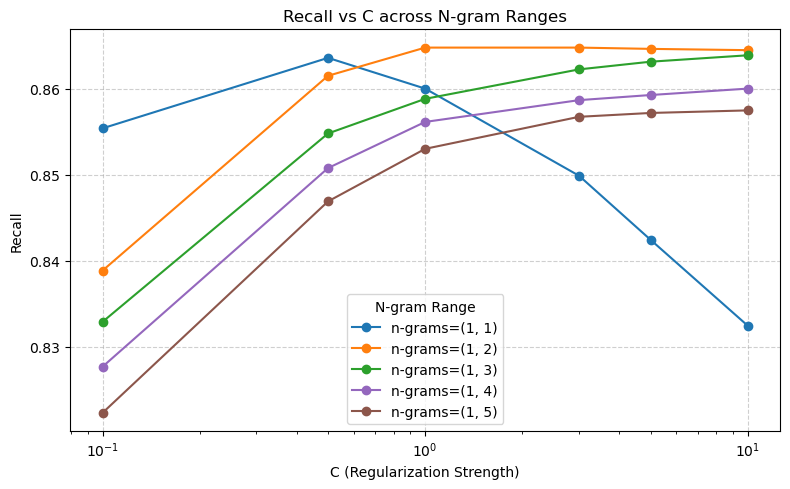

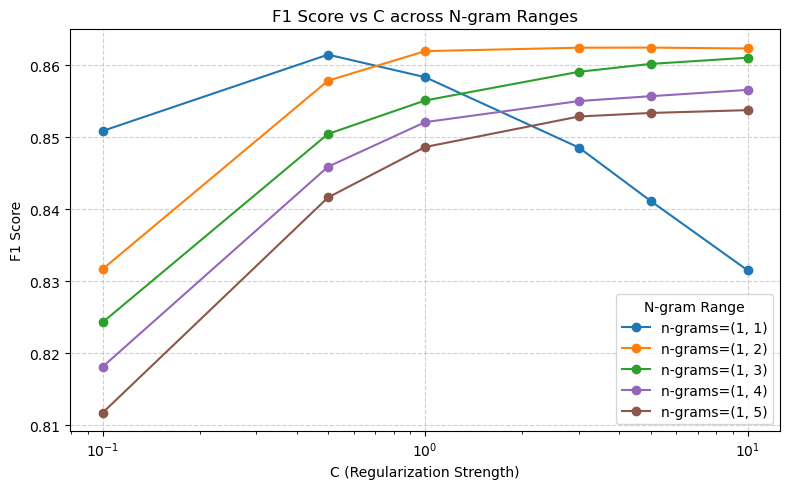

In [10]:
df = pd.DataFrame(results, columns=["ngram_range", "C", "Precision", "Recall", "F1"])

# Defining colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

# Plotting Precission
plt.figure(figsize=(8,5))
for i, ngram in enumerate(sorted(df["ngram_range"].unique())):
    subset = df[df["ngram_range"] == ngram]
    plt.plot(subset["C"], subset["Precision"], marker='o', color=colors[i], label=f"n-grams={ngram}")
plt.xscale('log')
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Precision")
plt.title("Precision vs C across N-gram Ranges")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="N-gram Range")
plt.tight_layout()
plt.show()

# Plotting Recall
plt.figure(figsize=(8,5))
for i, ngram in enumerate(sorted(df["ngram_range"].unique())):
    subset = df[df["ngram_range"] == ngram]
    plt.plot(subset["C"], subset["Recall"], marker='o', color=colors[i], label=f"n-grams={ngram}")
plt.xscale('log')
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Recall")
plt.title("Recall vs C across N-gram Ranges")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="N-gram Range")
plt.tight_layout()
plt.show()

# Plotting F1
plt.figure(figsize=(8,5))
for i, ngram in enumerate(sorted(df["ngram_range"].unique())):
    subset = df[df["ngram_range"] == ngram]
    plt.plot(subset["C"], subset["F1"], marker='o', color=colors[i], label=f"n-grams={ngram}")
plt.xscale('log')
plt.xlabel("C (Regularization Strength)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs C across N-gram Ranges")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="N-gram Range")
plt.tight_layout()
plt.show()


As per the plots above, it is observed that there is a rise in the model performance at the Bi-Gram level at C=5, wheere the F1_Score found to be 0.862, comparitevly higher to the optimized processed steps which is of 0.857 and the precision to be 0.864 and recall to be 0.865, which is also comparitevely higher than earlier steps.

# Additional Optimization: Stylistic + Lexicon Features

In [11]:
# Custom transformer to extract simple stylistic features
class StylisticFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        for text in X:
            words = text.split()
            num_words = len(words)
            avg_word_len = np.mean([len(w) for w in words]) if words else 0
            exclamations = text.count('!')
            questions = text.count('?')
            features.append([num_words, avg_word_len, exclamations, questions])
        return np.array(features)


In [12]:
# Downloading Liu's Opinion Lexicon (positive + negative)
pos_url = "https://www.cs.uic.edu/~liub/FBS/positive-words.txt"
neg_url = "https://www.cs.uic.edu/~liub/FBS/negative-words.txt"

for url, filename in [(pos_url, "positive-words.txt"), (neg_url, "negative-words.txt")]:
    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)

print("Lexicon files downloaded successfully!")


Lexicon files downloaded successfully!


In [13]:
# Loading opinion lexicon (positive and negative words)
def load_lexicon(pos_path, neg_path):
    with open(pos_path, 'r', encoding='utf-8', errors='ignore') as f:
        pos_words = set(f.read().split())
    with open(neg_path, 'r', encoding='utf-8', errors='ignore') as f:
        neg_words = set(f.read().split())
    return pos_words, neg_words

pos_words, neg_words = load_lexicon('positive-words.txt', 'negative-words.txt')

# Custom transformer to count positive/negative words per tweet
class LexiconFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            tokens = text.split()
            pos_count = sum(1 for t in tokens if t in pos_words)
            neg_count = sum(1 for t in tokens if t in neg_words)
            features.append([pos_count, neg_count])
        return np.array(features)


In [14]:
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words=None,
        ngram_range=(1, 2),
        sublinear_tf=True,
        max_df=0.95,
        min_df=2
    )),
    ('style', StylisticFeatures()),
    ('lexicon', LexiconFeatures())
])

final_pipeline = Pipeline([
    ('features', combined_features),
    ('svc', LinearSVC(C=5, class_weight='balanced', max_iter=30000))
])

print("Training final advanced model with stylistic + lexicon features...")
final_pipeline.fit(train_texts, train_labels)
preds = final_pipeline.predict(test_texts)

prec, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='weighted')
print("\n=== Final Model with Stylistic + Lexicon Features ===")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")


Training final advanced model with stylistic + lexicon features...


C:\Users\udayk\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Final Model with Stylistic + Lexicon Features ===
Precision: 0.863
Recall:    0.863
F1 Score:  0.863


After performing additional optimization using lexions features, the score is slightly pumped up with 0.863, with Bi Grams and C=5.

# Tabulating the results for all the processes worked till now.

In [15]:
data = {
    "Model": [
        "Baseline (Simple Preprocessing)",
        "Improved Preprocessing (Lemmatization + Stopword Removal)",
        "Unigrams + Bigrams",
        "Hyperparameter Tuning (C=0.1)",
        "TF-IDF + SVM",
        "TF-IDF + N-gram (1,2), C=5 (Best Grid Search)",
        "Additional Optimization with Stylistic + Lexicon Features"
    ],
    "Precision": [0.838, 0.841, 0.855, 0.857, 0.857, 0.864, 0.863],
    "Recall":    [0.840, 0.843, 0.857, 0.859, 0.856, 0.865, 0.864],
    "F1 Score":  [0.838, 0.842, 0.855, 0.857, 0.851, 0.862, 0.863]
}

# Converting to DataFrame
df = pd.DataFrame(data)

# Formatting to 3 decimal places (removes trailing zeros)
df = df.round(3)

from IPython.display import display, HTML
display(HTML(df.to_html(index=False, justify='center', border=1)))


Model,Precision,Recall,F1 Score
Baseline (Simple Preprocessing),0.838,0.840,0.838
Improved Preprocessing (Lemmatization + Stopword Removal),0.841,0.843,0.842
Unigrams + Bigrams,0.855,0.857,0.855
Hyperparameter Tuning (C=0.1),0.857,0.859,0.857
TF-IDF + SVM,0.857,0.856,0.851
"TF-IDF + N-gram (1,2), C=5 (Best Grid Search)",0.864,0.865,0.862
Additional Optimization with Stylistic + Lexicon Features,0.863,0.864,0.863


### Final Model Summary & Observations

After performing all the related experiments on the **baseline model**, several **optimization techniques** were applied one by one, such as..

- **Preprocessing optimization** including *lemmatization*, *stopword removal*, and *lowercasing* of text.  
- Using **bi-grams** instead of only unigrams as an additional **feature extraction optimization**.  
- Applying **hyperparameter tuning** for the SVM model with different *C values* ranging from **0.1 to 10**.  
- Introducing **TF-IDF with SVM**, combined with **n-gram optimization** (from **1 gram to 5 grams**) to enhance text representation.  

Through these optimizations, the model’s performance improved significantly over the baseline.  
The **best F1-Score** achieved was **0.862**, with **Precision = 0.864** and **Recall = 0.865**.

Finally, by incorporating **additional optimizations** such as **stylistic features** and **lexicon-based features**, the model maintained high accuracy, with a slight improvement to an **F1-Score of 0.863**.

### Resources and Tools Used

- **Dataset:** Provided `sentiment-dataset.tsv` file from the coursework.  
- **Libraries:** NLTK, scikit learn, NumPy, pandas, matplotlib (all standard NLP toolkits).  
- **External Resource:** [Liu’s Opinion Lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon)  
 used to incorporate lexicon based sentiment features.  
- **Other Tools:**  
  - `requests` for downloading lexicon data  
  - `IPython.display` for styled results tables  

